Random Forests is a Machine Learning algorithm that tackles one of the biggest problems with Decision Trees: **variance=overfitting.**.

In classification problems, if the area under the training ROC curve is much larger than validation or test, the model is likely to suffer from overfitting.

#### Bagging: Bootstrap Aggregation
Bagging, short for Bootstrap Aggregation, is a technique developed by Leo Breiman, with the goal of reducing the variance of a learning model. Bagging is also model agnostic, so regardless of type of model you’re using, the process is the same. Bootstrapping creates multiple, smaller random datasets drawn from the same distribution.

Each of the bootstrapped datasets is used to train a model, and the outputs are then aggregated into one final result.

Each model is trained on a different dataset, because they’re bootstrapped. So inevitably, each model will make different mistakes, and have a distinct error and variance. Both the error and variance get reduced in the aggregation step where, literally in the case of Regression, they are averaged out.

And because you end up with a single model, which combines the output of multiple models, Bagging is called and ensemble technique.

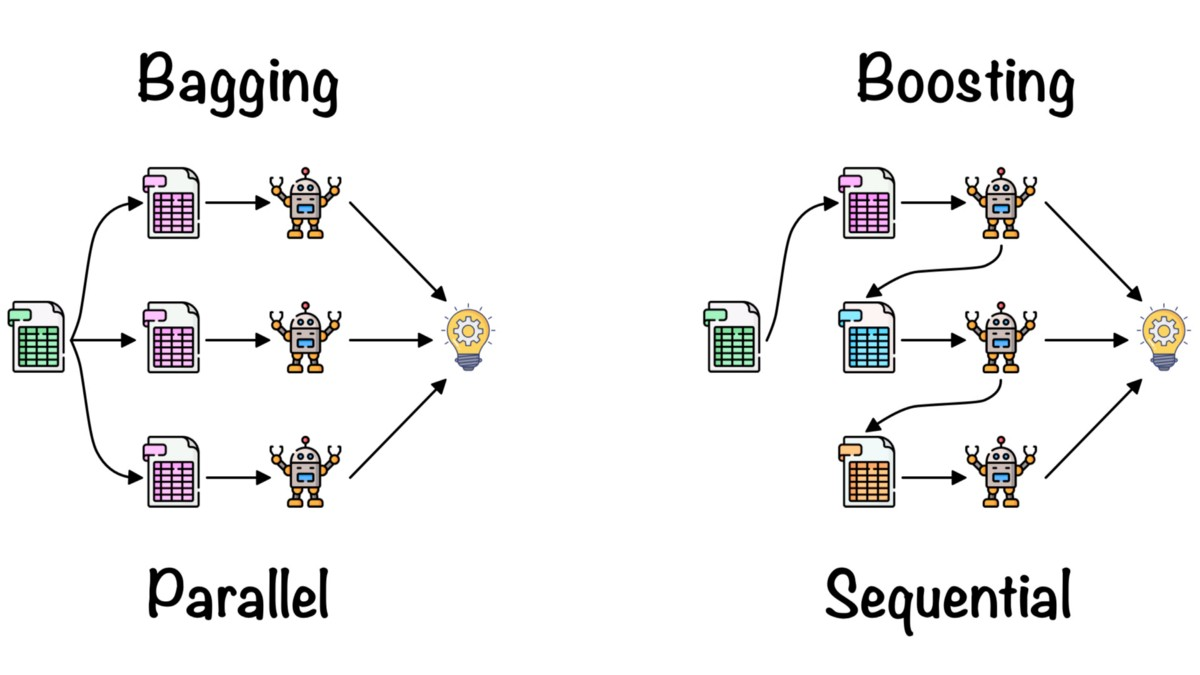

In [55]:
from IPython import display
display.Image("images/bagging_bootstrapping.png")

#### Random Forest

Random Forests was developed specifically to address the problem of high-variance in Decision Trees. Like the name suggests, you’re not training a single Decision Tree, you’re training an entire forest! In this case, a forest of Bagged Decision Trees.

At a high-level, in pseudo-code, Random Forests algorithm follows these steps:

1. Take the original dataset and create N bagged samples of size n, with n smaller than the original dataset.
2. Train a Decision Tree with each of the N bagged datasets as input. But, when doing a node split, don’t explore all features in the dataset. Randomly select a smaller number, M features, from all the features in training set. Then pick the best split using impurity measures, like Gini Impurity or Entropy.
3. Aggregate the results of the individual decision trees into a single output.
4. Prediction:
    - Average the values for each observation, produced by each tree, if you’re working on a Regression task.
    - Do a majority vote across all trees or average of probabilities, for each observation, if you’re working on a Classification task.

Random forests is difficult to interpret, while a decision tree is easily interpretable and can be converted to rules.

In [100]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import multiprocessing

import warnings
warnings.filterwarnings('ignore')


### 1. Our data

#### Iris dataset

In [101]:
from sklearn import datasets

# Creating a DataFrame of given iris dataset.
import pandas as pd
df=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
df.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 2. Split data intro train/test

#### Define feature and target matrix

In [62]:
features = list(df.columns)
target = 'species'
features.remove(target)

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  
                                                    random_state=0, 
                                                    stratify = y)  

## 3. Training Machine Learning Models 


In [74]:
# Preprocessing:
numerical_features = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

numerical_transformer = Pipeline(
    steps = [
        ("missing_values", SimpleImputer(strategy="mean"))
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
    ],
    remainder='passthrough'
)

# Union preprocessing + classifier
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

In [75]:
param_grid = {
    "classifier__max_depth": [5,6,7,8,9,10],
    "classifier__n_estimators": [10,50,100,200,500,1000],
}


In [78]:
search = GridSearchCV(clf, 
                      param_grid, 
                      n_jobs=1, 
                      verbose=4,
                      cv = 5,
                      return_train_score=True)

In [79]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END classifier__max_depth=5, classifier__n_estimators=10;, score=(train=0.979, test=1.000) total time=   0.0s
[CV 2/5] END classifier__max_depth=5, classifier__n_estimators=10;, score=(train=0.979, test=0.958) total time=   0.0s
[CV 3/5] END classifier__max_depth=5, classifier__n_estimators=10;, score=(train=0.979, test=0.917) total time=   0.0s
[CV 4/5] END classifier__max_depth=5, classifier__n_estimators=10;, score=(train=1.000, test=0.958) total time=   0.0s
[CV 5/5] END classifier__max_depth=5, classifier__n_estimators=10;, score=(train=1.000, test=0.917) total time=   0.0s
[CV 1/5] END classifier__max_depth=5, classifier__n_estimators=50;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5] END classifier__max_depth=5, classifier__n_estimators=50;, score=(train=1.000, test=0.958) total time=   0.1s
[CV 3/5] END classifier__max_depth=5, classifier__n_estimators=50;, score=(train=1.000, test=0.917) total

[CV 1/5] END classifier__max_depth=7, classifier__n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5] END classifier__max_depth=7, classifier__n_estimators=100;, score=(train=1.000, test=0.958) total time=   0.1s
[CV 3/5] END classifier__max_depth=7, classifier__n_estimators=100;, score=(train=1.000, test=0.917) total time=   0.1s
[CV 4/5] END classifier__max_depth=7, classifier__n_estimators=100;, score=(train=1.000, test=0.958) total time=   0.1s
[CV 5/5] END classifier__max_depth=7, classifier__n_estimators=100;, score=(train=1.000, test=0.917) total time=   0.1s
[CV 1/5] END classifier__max_depth=7, classifier__n_estimators=200;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5] END classifier__max_depth=7, classifier__n_estimators=200;, score=(train=1.000, test=0.958) total time=   0.2s
[CV 3/5] END classifier__max_depth=7, classifier__n_estimators=200;, score=(train=1.000, test=0.917) total time=   0.2s
[CV 4/5] END classifier__max_depth=7, cl

[CV 5/5] END classifier__max_depth=9, classifier__n_estimators=200;, score=(train=1.000, test=0.917) total time=   0.2s
[CV 1/5] END classifier__max_depth=9, classifier__n_estimators=500;, score=(train=1.000, test=1.000) total time=   0.5s
[CV 2/5] END classifier__max_depth=9, classifier__n_estimators=500;, score=(train=1.000, test=0.958) total time=   0.5s
[CV 3/5] END classifier__max_depth=9, classifier__n_estimators=500;, score=(train=1.000, test=0.917) total time=   0.6s
[CV 4/5] END classifier__max_depth=9, classifier__n_estimators=500;, score=(train=1.000, test=0.958) total time=   0.5s
[CV 5/5] END classifier__max_depth=9, classifier__n_estimators=500;, score=(train=1.000, test=0.917) total time=   0.5s
[CV 1/5] END classifier__max_depth=9, classifier__n_estimators=1000;, score=(train=1.000, test=1.000) total time=   1.1s
[CV 2/5] END classifier__max_depth=9, classifier__n_estimators=1000;, score=(train=1.000, test=0.958) total time=   1.1s
[CV 3/5] END classifier__max_depth=9, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('missing_values',
                                                                                          SimpleImputer())]),
                                                                         ['sepal '
                                                                          'length',
                                                                          'sepal '
                                                                          'width',
                                                                          'petal '
                                                                          'length',
                                                                          'petal '
                                                                          'width'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [5, 6, 7, 8, 9, 10],
                         'classifier__n_estimators': [10, 50, 100, 200, 500,
                                                      1000]},
             return_train_score=True, verbose=4)

#### Best model

In [80]:
# best model
best_model = search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('missing_values',
                                                                   SimpleImputer())]),
                                                  ['sepal length',
                                                   'sepal width',
                                                   'petal length',
                                                   'petal width'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=10))])

#### Overfitting

/Users/lidiacerdanorts/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


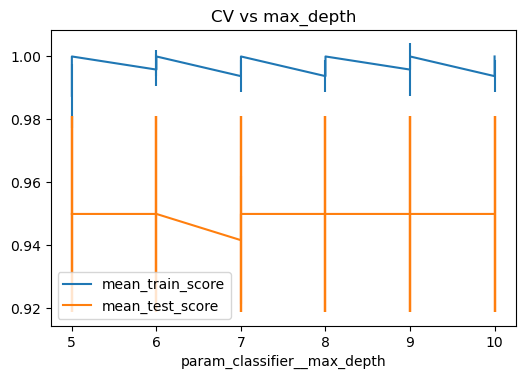

In [81]:
# max_depth 
cv_results = pd.DataFrame(search.cv_results_)

fig, ax = plt.subplots(figsize=(6, 3.84))
cv_results.plot(x='param_classifier__max_depth', y='mean_train_score', yerr='std_train_score', ax=ax)
cv_results.plot(x='param_classifier__max_depth', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("CV vs max_depth");

/Users/lidiacerdanorts/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


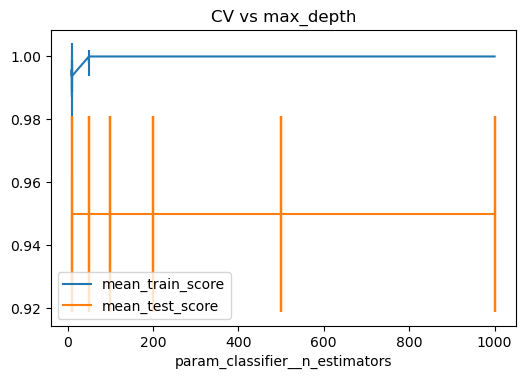

In [86]:
# n_estimators 
cv_results = pd.DataFrame(search.cv_results_)
cv_results = cv_results.sort_values(by = "param_classifier__n_estimators")

fig, ax = plt.subplots(figsize=(6, 3.84))
cv_results.plot(x='param_classifier__n_estimators', y='mean_train_score', yerr='std_train_score', ax=ax)
cv_results.plot(x='param_classifier__n_estimators', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("CV vs max_depth");

It is observed that there comes a point where the algorithm stops improving.

#### Feature importance


In [90]:
# Random Forest feature importance
feature_imp = pd.Series(search.best_estimator_._final_estimator.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
feature_imp

petal length (cm)    0.567245
petal width (cm)     0.351358
sepal length (cm)    0.064590
sepal width (cm)     0.016808
dtype: float64

In [105]:
# get std from all feature importance of each estimator
std = np.std([tree.feature_importances_ for tree in search.best_estimator_._final_estimator.estimators_], axis=0)

Let’s plot the impurity-based importance.

In [110]:
forest_importances = pd.DataFrame(feature_imp, columns = ["importance"])
forest_importances

,importance
petal length (cm),0.567245
petal width (cm),0.351358
sepal length (cm),0.064590
sepal width (cm),0.016808


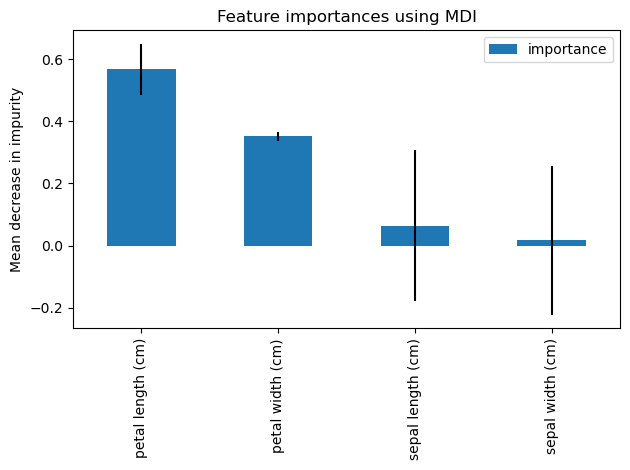

In [111]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()